In [110]:
import requests
import datetime
import apimoex
import pandas as pd
import numpy as np
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from scipy.optimize import minimize, milp, brute
import itertools
import kmedoids
import fastdtw
import scipy.spatial.distance as sd
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error

In [2]:
request_url = ('https://iss.moex.com/iss/engines/stock/'
               'markets/shares/boards/TQBR/securities.json')
arguments = {'securities.columns': ('SECID,'
                                    'REGNUMBER,'
                                    'LOTSIZE,'
                                    'SHORTNAME')}
with requests.Session() as session:
    iss = apimoex.ISSClient(session, request_url, arguments)
    lots = iss.get()
    lots = pd.DataFrame(lots['securities'])
    lots.set_index('SECID', inplace=True)

In [3]:
lots

,REGNUMBER,LOTSIZE,SHORTNAME
SECID,,,
ABIO,1-01-08902-A,10,iАРТГЕН ао
ABRD,1-02-12500-A,10,АбрауДюрсо
ACKO,1-01-52065-Z,100,АСКО ао
AFKS,1-05-01669-A,100,Система ао
AFLT,1-01-00010-A,10,Аэрофлот
...,...,...,...
YNDX,None,1,Yandex clA
YRSB,1-01-50099-A,10,ТНСэнЯр
YRSBP,2-01-50099-A,10,ТНСэнЯр-п


Берем данные по составу биржевого индекса, его динамике и ценам акций, входящих в него

In [16]:
imoex = pd.read_excel('/Users/bg/Documents/айвазян/imoex.xlsx', sheet_name='data')
imoex['TRADEDATE'] = pd.to_datetime(imoex['TRADEDATE'], format = '%d.%m.%Y')
def create_dataframe(start_date, end_date, stocks):
    df = imoex.loc[(imoex['TRADEDATE'] >= start_date) & (imoex['TRADEDATE'] <= end_date)][['CLOSE','TRADEDATE']].rename(columns={'CLOSE':'IMOEX'})
    df.set_index('TRADEDATE', inplace=True)
    for stock in stocks:
        with requests.Session() as session:
            data = apimoex.get_board_history(session, stock)
            df1 = pd.DataFrame(data)
            df1['TRADEDATE'] = pd.to_datetime(df1['TRADEDATE'], format='%Y-%m-%d')
            df1 = df1.loc[(df1['TRADEDATE'] >= start_date) & (df1['TRADEDATE'] <= end_date)][['CLOSE','TRADEDATE']].rename(columns={'CLOSE':stock})
            df1.set_index('TRADEDATE', inplace=True)
            df = df.join(df1)
        print(stock, end = ", ")
    return df

In [8]:
weights = pd.read_excel('calculation.xlsx', sheet_name=start_date, skiprows=3).dropna()

In [10]:
start_date = '16.09.2022'
end_date = '22.09.2023'
dataset = create_dataframe(start_date, end_date, weights['Code'])

GAZP
LKOH
SBER
SBERP
GMKN
NVTK
YNDX
ROSN
PLZL
MGNT
TATN
TCSG
PHOR
MTSS
SNGS
SNGSP
POLY
CHMF
ALRS
NLMK
RUAL
MOEX
IRAO
FIVE
VTBR
HYDR
MAGN
PIKK
TRNFP
RTKM
ENPG
TATNP
OZON
VKCO
CBOM
GLTR
AFKS
FIXP
AFLT
DSKY


In [11]:
start_date = '23.09.2023'
end_date = '21.12.2023'
test_dataset = create_dataframe(start_date, end_date, weights['Code'])

GAZP
LKOH
SBER
SBERP
GMKN
NVTK
YNDX
ROSN
PLZL
MGNT
TATN
TCSG
PHOR
MTSS
SNGS
SNGSP
POLY
CHMF
ALRS
NLMK
RUAL
MOEX
IRAO
FIVE
VTBR
HYDR
MAGN
PIKK
TRNFP
RTKM
ENPG
TATNP
OZON
VKCO
CBOM
GLTR
AFKS
FIXP
AFLT
DSKY


In [188]:
dataset

,IMOEX,GAZP,LKOH,SBER,SBERP,GMKN,NVTK,YNDX,ROSN,PLZL,...,ENPG,TATNP,OZON,VKCO,CBOM,GLTR,AFKS,FIXP,AFLT,DSKY
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2022-09-16,2435.18,243.80,4519.0,137.73,130.52,16228.0,1180.0,2206.0,359.05,8032.0,...,519.0,412.9,1464.5,510.0,5.992,385.00,14.831,385.7,29.18,83.14
2022-09-19,2430.54,244.21,4496.0,138.04,130.27,16016.0,1171.8,2230.0,358.25,8072.0,...,496.0,412.9,1488.0,550.2,6.135,363.50,14.889,391.9,28.96,83.94
2022-09-20,2215.67,221.15,4055.0,125.10,121.45,15260.0,1044.0,2010.0,330.90,7448.0,...,435.0,385.0,1325.5,493.0,5.999,322.35,13.584,366.0,27.46,77.28
2022-09-21,2130.71,214.07,3955.0,120.23,116.12,14776.0,1009.2,1899.4,312.55,7019.5,...,419.0,361.0,1236.0,447.6,5.959,322.00,12.619,335.9,26.22,72.62
2022-09-22,2190.87,231.45,4011.0,124.31,119.23,14794.0,1016.6,1916.8,315.50,6949.5,...,416.5,386.0,1254.0,469.6,6.035,317.00,12.781,344.0,26.86,73.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,3135.18,172.80,6526.0,259.07,258.73,16308.0,1636.2,2518.0,557.10,11642.0,...,516.6,604.6,2722.0,666.0,6.829,679.00,17.469,397.5,41.52,65.52
2023-09-19,3083.85,168.93,6344.0,252.72,252.59,15998.0,1599.6,2442.2,544.00,11352.0,...,495.0,599.8,2639.5,NaN,6.859,656.35,17.060,373.1,40.25,65.00
2023-09-20,3068.15,169.11,6423.0,253.77,253.59,16190.0,1625.6,2418.0,529.35,11418.5,...,495.2,600.4,2600.0,NaN,6.765,635.80,17.327,369.3,40.14,78.00


In [5]:
def transformation(data):
    return data * np.hstack([[1],lots.loc[data.drop(columns='IMOEX').columns,:]['LOTSIZE'].to_numpy()]) / 1000

In [6]:
def transformation_back(data):
    return data / np.hstack([[1],lots.loc[data.drop(columns='IMOEX').columns,:]['LOTSIZE'].to_numpy()]) *1000

In [232]:
dataset = transformation(dataset)

In [233]:
test_dataset = transformation(test_dataset)

# Случайный подход

In [196]:
test_dataset.iloc[-1].loc[weights['Code']].to_numpy()

array([  1615.7 ,   6702.  ,   2651.9 ,   2647.2 ,  17082.  ,   1478.2 ,
         2267.2 ,    577.1 ,  10593.5 ,   6704.5 ,    658.5 ,   3006.  ,
         6808.  ,   2488.5 ,   2756.  ,   5683.  ,    530.4 ,   1336.6 ,
          712.1 ,   1757.2 ,    348.55,   1929.  ,    399.  ,   1994.  ,
          229.35,    724.3 ,    519.25,    669.  , 143250.  ,    715.  ,
          446.2 ,    656.5 ,   2633.  ,    563.6 ,    783.9 ,    608.2 ,
         1583.6 ,    286.8 ,    359.3 ,    614.  ])

In [90]:
def simple_approach(dataset,test_dataset, budget=100000, num_components = 5, weights=None, thr = 3):
    dataset = dataset.dropna(axis=1, thresh=dataset.shape[0]//thr).dropna()
    weights = weights[weights['Code'].isin(list(dataset.columns))]
    weights = weights.iloc[np.argpartition(weights.iloc[:,-1], -num_components)[-num_components:]]
    w_ = transorm_budget(weights.iloc[:,-1],budget, list(dataset.iloc[-1].loc[weights['Code']]))
    choice = dataset.loc[:,weights['Code']].loc[:,w_ > 0].columns
    return choice, w_[w_>0]

In [253]:
test_dataset

,IMOEX,GAZP,LKOH,SBER,SBERP,GMKN,NVTK,YNDX,ROSN,PLZL,...,ENPG,TATNP,OZON,VKCO,CBOM,GLTR,AFKS,FIXP,AFLT,DSKY
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2023-09-25,3.04539,1.6587,6.4490,2.5265,2.5240,15.872,1.6052,2.3910,0.52065,11.0320,...,0.5040,0.5943,2.5400,NaN,0.6820,0.62125,1.6965,0.3577,0.4021,0.6850
2023-09-26,3.05191,1.6536,6.3860,2.5587,2.5545,15.946,1.6280,2.3910,0.51785,11.0940,...,0.5030,0.5930,2.5795,NaN,0.6964,0.62100,1.7080,0.3579,0.4029,0.6770
2023-09-27,3.06761,1.6553,6.4900,2.5610,2.5560,16.074,1.6472,2.4538,0.52995,11.2230,...,0.5134,0.6021,2.6750,NaN,0.6951,0.64860,1.7388,0.3682,0.4172,0.6864
2023-09-28,3.10807,1.6958,6.6455,2.5767,2.5728,16.304,1.6640,2.4394,0.53570,11.2370,...,0.5306,0.6088,2.6910,NaN,0.7065,0.66540,1.7253,0.3689,0.4143,0.6796
2023-09-29,3.13326,1.6709,6.6770,2.6072,2.6041,16.188,1.6662,2.4022,0.53700,11.4180,...,0.5222,0.6143,2.6360,NaN,0.7040,0.65900,1.7180,0.3621,0.4150,0.6976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-15,3.03389,1.6420,6.5600,2.6821,2.6770,16.988,1.4946,2.2244,0.56150,10.1940,...,0.4386,0.6332,2.6305,0.5668,0.7898,0.58495,1.5737,0.2678,0.3628,0.6010
2023-12-18,3.07626,1.6700,6.7235,2.6840,2.6811,17.150,1.5010,2.2504,0.56665,10.2425,...,0.4476,0.6417,2.7005,0.5830,0.8096,0.61355,1.5529,0.2756,0.3730,0.6036
2023-12-19,3.08364,1.6548,6.7090,2.6735,2.6718,17.202,1.5314,2.2422,0.57400,10.4035,...,0.4542,0.6530,2.6950,0.5780,0.7956,0.61540,1.5553,0.2955,0.3666,0.6272


# PCA для репликации индекса

## Шаг 1

На рассматриваемом историческом горизонте получаем оценку средней еженедельной доходности вложения в каждую акцию. Затем мы стандартизуем данные средних доходностей. Потом строим линейную регрессию относительно средней стандартизованной доходности всего индекса

In [76]:
def transorm_budget(weights, budget, prices):
    # use milp approach
    weights = np.array(weights)
    prices = np.array(prices)
    if len(weights) > 12:
        return (weights * budget / prices).astype(int) * prices / sum((weights * budget / prices).astype(int) * prices)
    def f(x):
      return sum((x*prices/sum(x*prices) - weights)**2)
    ranges = []
    for i in range(len(weights)):
        ranges.append(slice(int(weights[i] * budget / prices[i])-1, int(weights[i] * budget / prices[i])+2, 1))
    ranges = tuple(ranges)
    result = brute(f, ranges, disp=True, finish=None)
    return result / sum(result)

In [9]:
def approach_from_article(dataset, test_dataset, budget=100000, num_components = 5, thr = 3):
    weekly_average = dataset.dropna(axis=1, thresh=dataset.shape[0]//thr).groupby(pd.Grouper(freq='W')).mean().drop(columns=[]).dropna()
    changes = weekly_average.pct_change().dropna()
    normalized_changes=(changes-changes.mean())/changes.std()
    stocks = normalized_changes.drop(columns=['IMOEX'])
    index = normalized_changes['IMOEX']
    for column in stocks:
        n = len(index)
        data = stocks[column]
        b_coef = (n * sum(data * index) - sum(data) * sum(index)) / (n * sum(index**2) - sum(index)**2)
        a_coef = data.mean() - b_coef * index.mean()
        stocks[column] = data - a_coef - b_coef*index
    fa = FactorAnalyzer(rotation="varimax", n_factors=num_components, method='principal')
    fa.fit(stocks)
    loadings2 = pd.DataFrame(fa.loadings_, index=stocks.columns, columns=[f"Factor{i+1}" for i in range(num_components)])
    rotated_factor_pattern = loadings2[abs(loadings2) >= 0].dropna(how='all')
    # rotated_factor_pattern.style.highlight_max(color = 'lightgreen', axis = 0)
    choice = list(rotated_factor_pattern.idxmax())
    choice_stocks = normalized_changes[choice].to_numpy()
    def loss(x):
        return sum((choice_stocks @ x - normalized_changes['IMOEX'])**2)
    
    bnds = [(0, None) for _ in range(num_components)]
    cons = ({'type': 'eq', 'fun': lambda x: sum(x)-1})
    x0 = [1/num_components for _ in range(num_components)]
    res = minimize(loss, x0, tol=1e-6, bounds=bnds, constraints=cons)
    return choice, transorm_budget(list(res.x), budget, list(dataset.iloc[-1].loc[choice]))

In [10]:
def approach_modified(dataset, test_dataset, budget=100000, num_components = 5, thr = 3):
    weekly_average = dataset.dropna(axis=1, thresh=dataset.shape[0]//thr).groupby(pd.Grouper(freq='W')).mean().drop(columns=[]).dropna()
    changes = weekly_average.pct_change().dropna()
    normalized_changes=(changes-changes.mean())/changes.std()
    stocks = normalized_changes.drop(columns=['IMOEX'])
    index = normalized_changes['IMOEX']
    # without linear regression
    fa = FactorAnalyzer(rotation="varimax", n_factors=num_components, method='principal')
    fa.fit(stocks)    
    loadings2 = pd.DataFrame(fa.loadings_, index=stocks.columns, columns=[f"Factor{i+1}" for i in range(num_components)])
    rotated_factor_pattern = loadings2[abs(loadings2) >= 0].dropna(how='all')
    # rotated_factor_pattern.style.highlight_max(color = 'lightgreen', axis = 0)
    choice = list(rotated_factor_pattern.idxmax())
    choice_stocks = normalized_changes[choice].to_numpy()
    def loss(x):
        return sum((choice_stocks @ x - normalized_changes['IMOEX'])**2)
    bnds = [(0, None) for _ in range(num_components)]
    cons = ({'type': 'eq', 'fun': lambda x: sum(x)-1})
    x0 = [1/num_components for _ in range(num_components)]
    res = minimize(loss, x0, tol=1e-6, bounds=bnds, constraints=cons)
    return choice, transorm_budget(list(res.x), budget, list(dataset.iloc[-1].loc[choice]))

In [268]:
choice1, w1 = approach_from_article(dataset, budget=30, num_components=10)

In [269]:
choice2, w2 = simple_approach(dataset, budget=30)

In [270]:
choice3, w3 = approach_modified(dataset, budget=30, num_components=10)

In [271]:
t1 = test_dataset.dropna()[choice1]/test_dataset.dropna().iloc[0].loc[choice1] @ w1

In [272]:
t2 = test_dataset.dropna()[choice2]/test_dataset.dropna().iloc[0].loc[choice2] @ w2

In [273]:
t3 = test_dataset.dropna()[choice3]/test_dataset.dropna().iloc[0].loc[choice3] @ w3

In [260]:
t_real = test_dataset.dropna()['IMOEX']/test_dataset.dropna().iloc[0].loc['IMOEX']

<Axes: xlabel='TRADEDATE'>

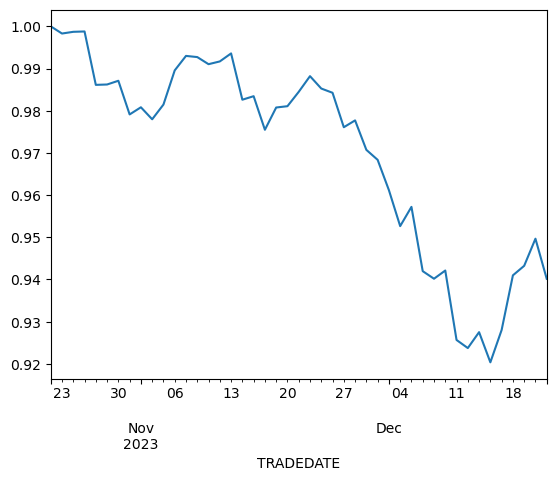

In [261]:
t_real.plot()

In [274]:
np.corrcoef(t1,t_real)

array([[1.        , 0.97514974],
       [0.97514974, 1.        ]])

<Axes: xlabel='TRADEDATE'>

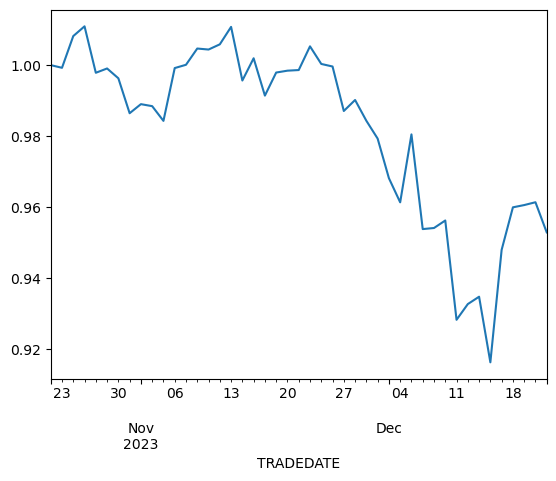

In [275]:
t1.plot()

In [276]:
np.corrcoef(t2,t_real)

array([[1.        , 0.95848248],
       [0.95848248, 1.        ]])

<Axes: xlabel='TRADEDATE'>

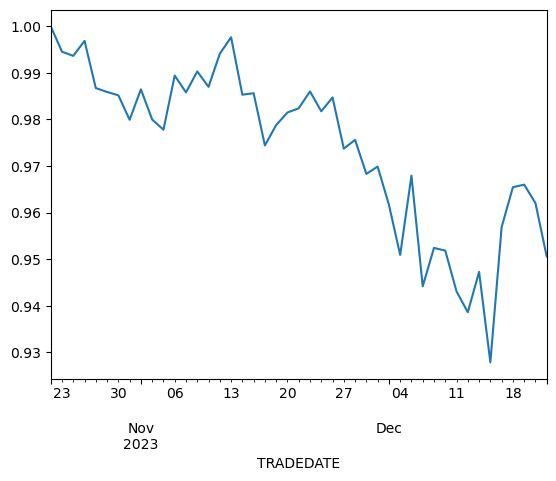

In [277]:
t2.plot()

In [266]:
np.corrcoef(t3,t_real)

array([[1.        , 0.67462403],
       [0.67462403, 1.        ]])

<Axes: xlabel='TRADEDATE'>

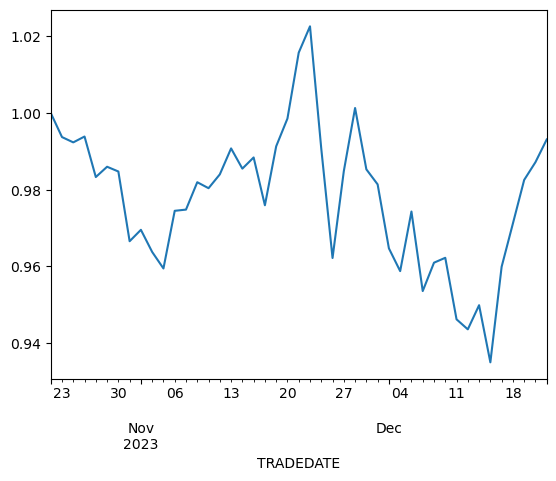

In [267]:
t3.plot()

# Кластеризация для репликации индекса

In [12]:
def approach_clusters_pcc(dataset, test_dataset, budget=100000, num_components = 5, thr = 3):
    weekly_average = dataset.dropna(axis=1, thresh=dataset.shape[0]//thr).groupby(pd.Grouper(freq='W')).mean().drop(columns=[]).dropna()
    changes = weekly_average.pct_change().dropna()
    normalized_changes=(changes-changes.mean())/changes.std()
    stocks = normalized_changes.drop(columns=['IMOEX'])
    index = normalized_changes['IMOEX']
    for column in stocks:
        n = len(index)
        data = stocks[column]
        b_coef = (n * sum(data * index) - sum(data) * sum(index)) / (n * sum(index**2) - sum(index)**2)
        a_coef = data.mean() - b_coef * index.mean()
        stocks[column] = data - a_coef - b_coef*index
    km = kmedoids.KMedoids(num_components, method='fasterpam')
    distmatrix = 1 - stocks.corr()
    c = km.fit(distmatrix)
    choice = list(stocks.columns[c.medoid_indices_])
    choice_stocks = normalized_changes[choice].to_numpy()
    def loss(x):
        return sum((choice_stocks @ x - normalized_changes['IMOEX'])**2)
    bnds = [(0, None) for _ in range(num_components)]
    cons = ({'type': 'eq', 'fun': lambda x: sum(x)-1})
    x0 = [1/num_components for _ in range(num_components)]
    res = minimize(loss, x0, tol=1e-6, bounds=bnds, constraints=cons)
    return choice, transorm_budget(list(res.x), budget, list(dataset.iloc[-1].loc[choice]))

In [349]:
choice4, w4 = approach_clusters_pcc(dataset, budget=30, num_components=30)

In [350]:
t4 = test_dataset.dropna()[choice4]/test_dataset.dropna().iloc[0].loc[choice4] @ w4

In [351]:
np.corrcoef(t4,t_real)

array([[1.        , 0.97361981],
       [0.97361981, 1.        ]])

<Axes: xlabel='TRADEDATE'>

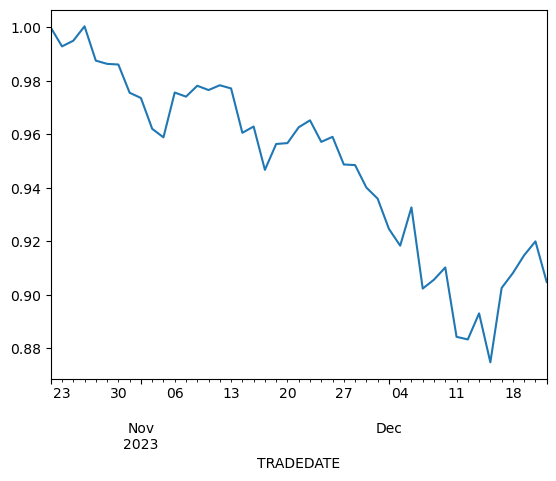

In [352]:
t4.plot()

In [11]:
def my_fastdtw(sales1, sales2):
    return fastdtw.fastdtw(sales1,sales2)[0]
    
def approach_clusters_dtw(dataset, test_dataset, budget=100000, num_components = 5, thr = 3):
    weekly_average = dataset.dropna(axis=1, thresh=dataset.shape[0]//thr).groupby(pd.Grouper(freq='W')).mean().drop(columns=[]).dropna()
    changes = weekly_average.pct_change().dropna()
    normalized_changes=(changes-changes.mean())/changes.std()
    stocks = normalized_changes.drop(columns=['IMOEX'])
    index = normalized_changes['IMOEX']
    for column in stocks:
        n = len(index)
        data = stocks[column]
        b_coef = (n * sum(data * index) - sum(data) * sum(index)) / (n * sum(index**2) - sum(index)**2)
        a_coef = data.mean() - b_coef * index.mean()
        stocks[column] = data - a_coef - b_coef*index
    km = kmedoids.KMedoids(num_components, method='fasterpam')
    distmatrix = squareform(sd.pdist(stocks.T.to_numpy(), my_fastdtw))
    c = km.fit(distmatrix)
    choice = list(stocks.columns[c.medoid_indices_])
    choice_stocks = normalized_changes[choice].to_numpy()
    def loss(x):
        return sum((choice_stocks @ x - normalized_changes['IMOEX'])**2)
    bnds = [(0, None) for _ in range(num_components)]
    cons = ({'type': 'eq', 'fun': lambda x: sum(x)-1})
    x0 = [1/num_components for _ in range(num_components)]
    res = minimize(loss, x0, tol=1e-6, bounds=bnds, constraints=cons)
    return choice, transorm_budget(list(res.x), budget, list(dataset.iloc[-1].loc[choice]))

In [429]:
choice5, w5 = approach_clusters_dtw(dataset, budget=100, num_components=12)

In [430]:
choice5, w5

(['CBOM',
  'HYDR',
  'NLMK',
  'AFKS',
  'NVTK',
  'SBERP',
  'DSKY',
  'TATN',
  'ROSN',
  'TRNFP',
  'SNGS',
  'ALRS'],
 array([0.        , 0.        , 0.02739726, 0.1369863 , 0.15068493,
        0.09589041, 0.        , 0.35616438, 0.        , 0.        ,
        0.09589041, 0.1369863 ]))

In [431]:
t5 = test_dataset.dropna()[choice5]/test_dataset.dropna().iloc[0].loc[choice5] @ w5

In [432]:
np.corrcoef(t5,t_real)

array([[1.        , 0.84811322],
       [0.84811322, 1.        ]])

<Axes: xlabel='TRADEDATE'>

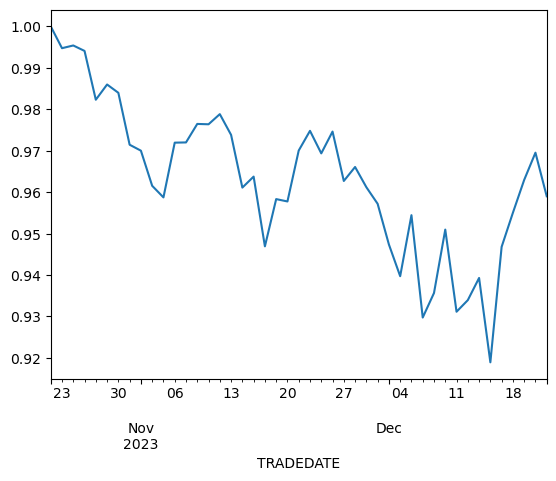

In [433]:
t5.plot()

# Графики качества повторения

Пишем функцию, которая поможет объединить различные тесты в один

Параметры:
- Число различных активов
- Бюджет вложения
- Мера сходства

  
На чем проверяем?
- Много наблюдений, сдвигающихся нанемного вправо каждый раз


Что делаем в итоге?
- Находим оптимальные портфелей, чтобы получать минимальную ошибку

По итогу получаем много квартальных прогнозов по данным за последний год

Смотрим, какой метод работает лучше всего, подбираем оптимальные параметры в зависимости от суммы инвестиций

Далее, проводим тесты на новых данных 

In [73]:
train_start_dates = ['17.06.2014', '16.09.2014', '16.12.2014','17.03.2015','16.06.2015', '16.09.2015', '16.12.2015','16.03.2016','16.06.2016','16.09.2016','16.12.2016',
               '17.03.2017', '16.06.2017', '22.09.2017', '22.12.2017', '16.03.2018', '22.06.2018','21.09.2018','21.12.2018','22.03.2019',
               '21.06.2019', '20.09.2019', '20.12.2019', '20.03.2020', '19.06.2020', '18.09.2020']
test_start_dates = ['16.06.2015', '16.09.2015','16.12.2015','16.03.2016','16.06.2016','16.09.2016','16.12.2016',
               '17.03.2017', '16.06.2017', '22.09.2017', '22.12.2017', '16.03.2018', '22.06.2018','21.09.2018','21.12.2018','22.03.2019',
               '21.06.2019', '20.09.2019', '20.12.2019', '20.03.2020', '19.06.2020', '18.09.2020', '18.12.2020','19.03.2021','18.06.2021',
               '17.09.2021']
test_end_dates = ['16.09.2015', '16.12.2015', '16.03.2016','16.06.2016','16.09.2016','16.12.2016',
               '17.03.2017', '16.06.2017', '22.09.2017', '22.12.2017', '16.03.2018', '22.06.2018','21.09.2018','21.12.2018','22.03.2019',
               '21.06.2019', '20.09.2019', '20.12.2019', '20.03.2020', '19.06.2020', '18.09.2020', '18.12.2020','19.03.2021','18.06.2021',
               '17.09.2021', '17.12.2021']


In [74]:
# get all stocks we need
all_stocks = []
for d in test_start_dates:
    all_stocks += list(pd.read_excel('calculation.xlsx', sheet_name=d, skiprows=3).dropna()['Code'])
all_stocks = list(set(all_stocks))
all_stocks = [s.strip('*') for s in all_stocks]

In [75]:
all_data = create_dataframe(train_start_dates[0], '01.01.2023', all_stocks)

EONR, AGRO, POGR, MTLR, TATNP, ALRS, NLMK, MVID, UPRO, POLY, CBOM, ROSN, URKA, MSNG, FIXP, TRMK, RTKMP, QIWI, LKOH, LSRG, BANEP, YNDX, RTKM, IRAO, RSTI, UWGN, BANE, PIKK, SBER, AFLT, SVAV, CHMF, RUAL, PGIL, VSMO, DIXY, LNTA, PHOR, AKRN, NMTP, PHST, MTLRP, DSKY, TCSG, MSTT, MFON, GLTR, NKNC, GCHE, FIVE, RUALR, MAGN, MAIL, SNGSP, PLZL, MGNT, GAZP, MOEX, TRNFP, FEES, OZON, TATN, VTBR, SBERP, RNFT, HYDR, AFKS, EPLN, SNGS, NVTK, HHRU, GMKN, MTSS, SFIN, 

In [78]:
for c in all_data.columns:
    if c not in lots.index:
        df2 = pd.DataFrame([['?',1,'?']], columns=['REGNUMBER',	'LOTSIZE',	'SHORTNAME'], index=[c])
        lots = pd.concat([lots,df2])

In [467]:
#def transformation(data):
#    return data * np.hstack([[1],lots.loc[data.drop(columns='IMOEX').columns,:]['LOTSIZE'].to_numpy()]) / 1000

In [79]:
all_data = transformation(all_data)

In [80]:
def evaluate(train_data, test_data, approach, budget, n, weights):
    choice, w = None, None
    if approach == 'cluster_pcc':
        choice, w = approach_clusters_pcc(train_data, test_data, budget=budget, num_components=n)
    elif approach == 'naive':
        choice, w = simple_approach(train_data, test_data, budget=budget, num_components=n, weights = weights)
    elif approach == 'cluster_dtw':
        choice, w = approach_clusters_dtw(train_data, test_data, budget=budget, num_components=n)
    elif approach == 'pca':
        choice, w = approach_from_article(train_data, test_data, budget=budget, num_components=n)
    t = test_data.dropna()[choice]/test_data.dropna().iloc[0].loc[choice] @ w
    t_real = test_data.dropna()['IMOEX']/test_data.dropna().iloc[0].loc['IMOEX']
    return (np.corrcoef(t,t_real)[1][0],my_fastdtw(t,t_real), mean_squared_error(t,t_real))

In [81]:
def next_day(date):
    return (datetime.datetime.strptime(date, "%d.%m.%Y").date() + datetime.timedelta(days=1)).strftime("%d.%m.%Y")

In [82]:
def next_week(date):
    return (datetime.datetime.strptime(date, "%d.%m.%Y").date() + datetime.timedelta(days=7)).strftime("%d.%m.%Y")

In [92]:
def get_sample(approach, budget, n):
    ans = []
    for i in range(len(train_start_dates)):
        d1 = train_start_dates[i]
        d2 = test_start_dates[i]
        d3 = test_end_dates[i]
        for shift in range(12):
            weights = pd.read_excel('calculation.xlsx', sheet_name=test_start_dates[i], skiprows=3).dropna()
            cols = ['IMOEX'] + list(weights['Code'])
            train_data = all_data.loc[d1 :d2].loc[:, cols]
            test_data = all_data.loc[d2: d3].loc[:, cols]
            try:
                res = evaluate(train_data, test_data, approach, budget, n, weights)
                ans.append(res)
            except:
                pass
            d1 = next_week(d1)
            d2 = next_week(d2)
            d3 = next_week(d3)
    return ans

In [97]:
import warnings
warnings.filterwarnings("ignore")

# Сравнение методов для трех акций и 50 тыс. вложений

In [98]:
naive_sample = get_sample('naive', 50, 3)

In [99]:
pcc_sample = get_sample('cluster_pcc', 50, 3)

In [100]:
dtw_sample = get_sample('cluster_dtw', 50, 3)

In [101]:
pca_sample = get_sample('pca', 50, 3)

In [114]:
res_df1 = pd.DataFrame({'naive': [el[0] for el in naive_sample], 'cluster_pcc': [el[0] for el in pcc_sample], 'cluster_dtw': [el[0] for el in dtw_sample], 'pca':[el[0] for el in pca_sample]}).dropna()

In [116]:
res_df2 = pd.DataFrame({'naive': [el[1] for el in naive_sample], 'cluster_pcc': [el[1] for el in pcc_sample], 'cluster_dtw': [el[1] for el in dtw_sample], 'pca':[el[1] for el in pca_sample]}).dropna()

In [120]:
res_df3 = pd.DataFrame({'naive': [el[2] for el in naive_sample], 'cluster_pcc': [el[2] for el in pcc_sample], 'cluster_dtw': [el[2] for el in dtw_sample], 'pca':[el[2] for el in pca_sample]}).dropna()



<Axes: ylabel='Density'>

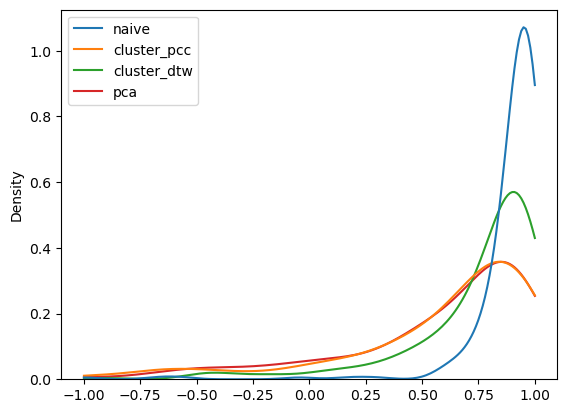

In [118]:
sns.kdeplot(data=res_df1, clip=(-1,1))

<Axes: ylabel='Density'>

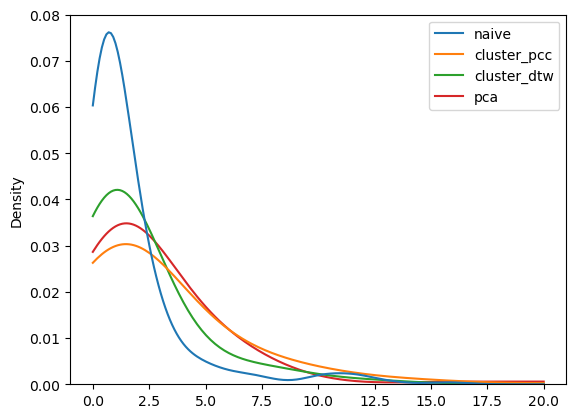

In [119]:
sns.kdeplot(data=res_df2, clip=(0,20))

<Axes: ylabel='Density'>

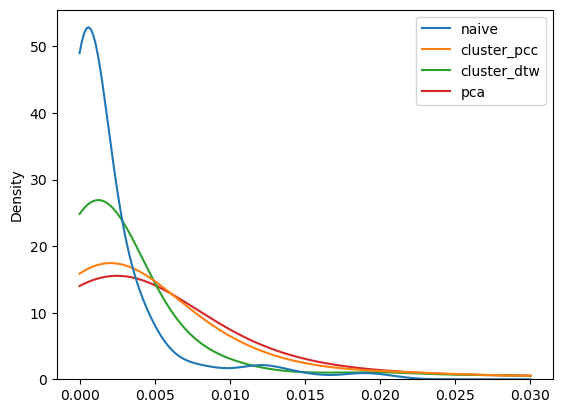

In [122]:
sns.kdeplot(data=res_df3, clip = (0,0.03))

# Сравнение методов для десяти акций и 50 тыс. вложений

In [141]:
naive_sample = get_sample('naive', 50, 10)

In [142]:
pcc_sample = get_sample('cluster_pcc', 50, 10)

In [143]:
dtw_sample = get_sample('cluster_dtw', 50, 10)

In [144]:
pca_sample = get_sample('pca', 50, 10)

In [145]:
mn = min(len(naive_sample),len(pcc_sample), len(dtw_sample), len(pca_sample))

In [146]:
res_df1 = pd.DataFrame({'naive': [el[0] for el in naive_sample[:mn]], 'cluster_pcc': [el[0] for el in pcc_sample[:mn]], 'cluster_dtw': [el[0] for el in dtw_sample[:mn]], 'pca':[el[0] for el in pca_sample[:mn]]}).dropna()

In [147]:
res_df2 = pd.DataFrame({'naive': [el[1] for el in naive_sample[:mn]], 'cluster_pcc': [el[1] for el in pcc_sample[:mn]], 'cluster_dtw': [el[1] for el in dtw_sample[:mn]], 'pca':[el[1] for el in pca_sample[:mn]]}).dropna()

In [148]:
res_df3 = pd.DataFrame({'naive': [el[2] for el in naive_sample[:mn]], 'cluster_pcc': [el[2] for el in pcc_sample[:mn]], 'cluster_dtw': [el[2] for el in dtw_sample[:mn]], 'pca':[el[2] for el in pca_sample[:mn]]}).dropna()


<Axes: ylabel='Density'>

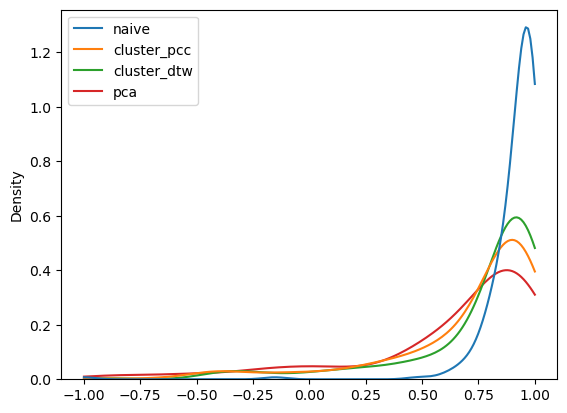

In [149]:
sns.kdeplot(data=res_df1, clip=(-1,1))

<Axes: ylabel='Density'>

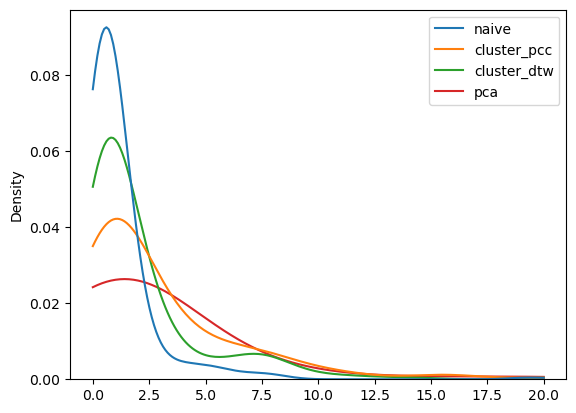

In [150]:
sns.kdeplot(data=res_df2, clip=(0,20))

<Axes: ylabel='Density'>

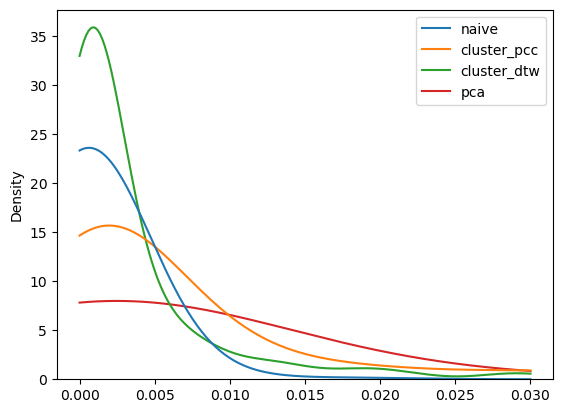

In [151]:
sns.kdeplot(data=res_df3, clip = (0,0.03))

# Сравнение методов для двадцати акций и 50 тыс. вложений

In [153]:
naive_sample = get_sample('naive', 50, 20)

In [154]:
pcc_sample = get_sample('cluster_pcc', 50, 20)

In [155]:
dtw_sample = get_sample('cluster_dtw', 50, 20)

In [156]:
pca_sample = get_sample('pca', 50, 20)

In [157]:
mn = min(len(naive_sample),len(pcc_sample), len(dtw_sample), len(pca_sample))

In [158]:
res_df1 = pd.DataFrame({'naive': [el[0] for el in naive_sample[:mn]], 'cluster_pcc': [el[0] for el in pcc_sample[:mn]], 'cluster_dtw': [el[0] for el in dtw_sample[:mn]], 'pca':[el[0] for el in pca_sample[:mn]]}).dropna()

In [159]:
res_df2 = pd.DataFrame({'naive': [el[1] for el in naive_sample[:mn]], 'cluster_pcc': [el[1] for el in pcc_sample[:mn]], 'cluster_dtw': [el[1] for el in dtw_sample[:mn]], 'pca':[el[1] for el in pca_sample[:mn]]}).dropna()

In [160]:
res_df3 = pd.DataFrame({'naive': [el[2] for el in naive_sample[:mn]], 'cluster_pcc': [el[2] for el in pcc_sample[:mn]], 'cluster_dtw': [el[2] for el in dtw_sample[:mn]], 'pca':[el[2] for el in pca_sample[:mn]]}).dropna()


<Axes: ylabel='Density'>

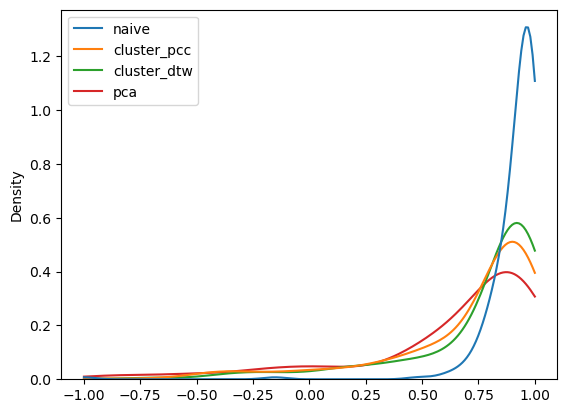

In [161]:
sns.kdeplot(data=res_df1, clip=(-1,1))

<Axes: ylabel='Density'>

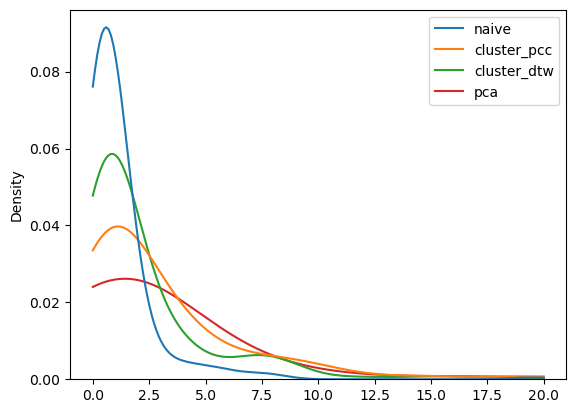

In [162]:
sns.kdeplot(data=res_df2, clip=(0,20))

<Axes: ylabel='Density'>

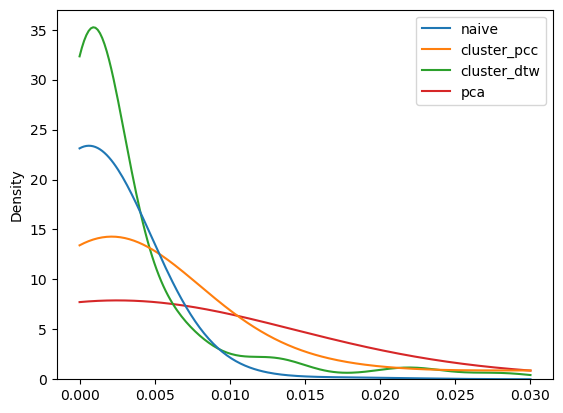

In [163]:
sns.kdeplot(data=res_df3, clip = (0,0.03))